In [1]:
import pandas as pd 
import matplotlib.pylab as plt 
import numpy as  np 
from xgboost import XGBRegressor
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split


In [2]:
df=pd.read_csv(r'C:\Users\aksha\coading\New folder (2)\data\recent\5_batteries.csv')
feature_list=df.columns
print(feature_list)

Index(['Cycle', 'Voltage_measured', 'Current_measured', 'Temperature_measured',
       'Time', 'Capacity', 'Battery_ID', 'capacity_fade_total',
       'capacity_fade_percent', 'capacity_rolling_mean_5',
       'capacity_rolling_std_5', 'capacity_trend_5', 'voltage_rolling_mean_5',
       'temp_rolling_mean_5', 'capacity_velocity', 'capacity_acceleration',
       'cycle_normalized', 'cycles_from_start', 'voltage_change',
       'resistance_proxy', 'internal_resistance', 'energy_discharged',
       'power_avg', 'voltage_efficiency', 'discharge_capacity_ratio',
       'temp_capacity_interaction', 'voltage_capacity_ratio',
       'power_to_energy_ratio', 'degradation_acceleration_abs',
       'remaining_capacity', 'estimated_cycles_to_eol'],
      dtype='object')


In [3]:
print(len(list(df.columns)))

31


### 2 strategy we wil use 
#### 1 train the model to know the feature importance 
#### 2 use important feature to train new model so that we could not miss out with importance features


In [4]:
# Exclude only target and leakage features
exclude = ['Cycle', 'Time', 'Capacity', 'Battery_ID',
           'capacity_fade_total', 'discharge_capacity_ratio', 
           'remaining_capacity']

features = [col for col in df.columns if col not in exclude]
# This gives us ~24-28 features

X = df[features]
y = df['Capacity']

In [5]:
# Train on 3 batteries
train_mask = df['Battery_ID'].isin(['B0005', 'B0006', 'B0007'])
test_mask = df['Battery_ID'] == 'B0018'

X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[test_mask]
y_test = y[test_mask]

print(f"Train: {len(X_train)} samples from 3 batteries")
print(f"Test: {len(X_test)} samples from 1 unseen battery")

Train: 489 samples from 3 batteries
Test: 127 samples from 1 unseen battery


In [6]:
### we have use the next battrey for testing 
#now lets train a model 
X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[test_mask]
y_test = y[test_mask]
model = XGBRegressor(n_estimators=100,
                     max_depth=6,
                     learning_rate=0.05,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     random_state=42
)
model.fit(X_train,y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [7]:
#lets get the feature importance 
y_pred=model.predict(X_test)


#metrics
r2=r2_score(y_test,y_pred)
rmse=np.sqrt(mean_squared_error(y_test,y_pred))


#lets have the feature importance 

importance =pd.DataFrame({
    "features":features,
    "importance":model.feature_importances_}).sort_values('importance',ascending=False)


print(f"R2 = {r2:.3f}")
print(f"top 10 Features:")
print(importance.head(10))

R2 = 0.997
top 10 Features:
                   features  importance
16        energy_discharged    0.437997
4   capacity_rolling_mean_5    0.393575
20   voltage_capacity_ratio    0.115247
1          Current_measured    0.034885
3     capacity_fade_percent    0.009845
17                power_avg    0.005852
14         resistance_proxy    0.001000
21    power_to_energy_ratio    0.000525
15      internal_resistance    0.000315
0          Voltage_measured    0.000132


In [8]:
top_15 = importance.head(15)['features'].tolist()
X_train_reduced = X_train[top_15]
X_test_reduced = X_test[top_15]

#lets get the feature importance 
y_pred=model.predict(X_test)


#metrics
r2=r2_score(y_test,y_pred)
rmse=np.sqrt(mean_squared_error(y_test,y_pred))


print(f"R2 = {r2:.3f}")
print(f"top 15 Features:")
print(importance.head(10))

R2 = 0.997
top 15 Features:
                   features  importance
16        energy_discharged    0.437997
4   capacity_rolling_mean_5    0.393575
20   voltage_capacity_ratio    0.115247
1          Current_measured    0.034885
3     capacity_fade_percent    0.009845
17                power_avg    0.005852
14         resistance_proxy    0.001000
21    power_to_energy_ratio    0.000525
15      internal_resistance    0.000315
0          Voltage_measured    0.000132


In [9]:
# Which one did you calculate?
# train_r2 = r2_score(X_test, y_test)  # Should be high
test_r2 = r2_score(y_test, y_pred)     # This is what matters!

In [10]:
# print(f"Train R²: {train_r2:.4f}")
print(f"Test R²:  {test_r2:.4f}")

# If both are 0.997 → DATA LEAKAGE!
# If train=0.997, test=0.90 → Overfitting but OK
# If train=0.85, test=0.997 → Something very wrong!

Test R²:  0.9973


In [11]:
# These should NOT be in your feature list:
leakage_features = [
    'capacity_fade_total',           # = initial - Capacity (direct!)
    'discharge_capacity_ratio',      # = Capacity / initial (direct!)
    'capacity_rolling_mean_5',       # Almost = Capacity itself
    'energy_discharged',             # = Capacity × Voltage (99% correlated)
    'remaining_capacity',            # = Capacity - EOL_threshold
]

# Check if any are in your features:
print("Features used:", features)
for leak in leakage_features:
    if leak in features:
        print(f"⚠️  LEAKAGE: {leak} is in features!")

Features used: ['Voltage_measured', 'Current_measured', 'Temperature_measured', 'capacity_fade_percent', 'capacity_rolling_mean_5', 'capacity_rolling_std_5', 'capacity_trend_5', 'voltage_rolling_mean_5', 'temp_rolling_mean_5', 'capacity_velocity', 'capacity_acceleration', 'cycle_normalized', 'cycles_from_start', 'voltage_change', 'resistance_proxy', 'internal_resistance', 'energy_discharged', 'power_avg', 'voltage_efficiency', 'temp_capacity_interaction', 'voltage_capacity_ratio', 'power_to_energy_ratio', 'degradation_acceleration_abs', 'estimated_cycles_to_eol']
⚠️  LEAKAGE: capacity_rolling_mean_5 is in features!
⚠️  LEAKAGE: energy_discharged is in features!


In [13]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

# Load your data
df2 = pd.read_csv(r'C:\Users\aksha\coading\New folder (2)\data\recent\5_batteries.csv')

print("="*60)
print("🔍 OVERFITTING / LEAKAGE DIAGNOSTIC")
print("="*60)

# Check which features you used
print("\n1️⃣ FEATURES USED:")
print("List your features here...")

# Check correlations with target
print("\n2️⃣ CORRELATION WITH TARGET (Capacity):")
correlations = []
for col in df2.columns:
    if col not in ['Battery_ID', 'Cycle']:
        try:
            corr = df2[col].corr(df2['Capacity'])
            correlations.append({'feature': col, 'correlation': abs(corr)})
        except:
            pass

corr_df = pd.DataFrame(correlations).sort_values('correlation', ascending=False)
print("\nTop 10 highest correlations:")
print(corr_df.head(10))

# Flag suspicious correlations
print("\n⚠️  LEAKAGE SUSPECTS (correlation > 0.95):")
leakage = corr_df[corr_df['correlation'] > 0.95]
if len(leakage) > 0:
    print(leakage)
    print("\n🚨 These features likely cause data leakage!")
else:
    print("✅ No obvious leakage")

# Check train vs test split
train_mask = df2['Battery_ID'].isin(['B0005', 'B0006', 'B0007'])
test_mask = df2['Battery_ID'] == 'B0018'

print(f"\n3️⃣ DATA SPLIT CHECK:")
print(f"Train batteries: {df[train_mask]['Battery_ID'].unique()}")
print(f"Train samples: {train_mask.sum()}")
print(f"Test battery: {df[test_mask]['Battery_ID'].unique()}")
print(f"Test samples: {test_mask.sum()}")

# Check if target distributions are similar
print(f"\n4️⃣ TARGET DISTRIBUTION:")
print(f"Train Capacity: {df[train_mask]['Capacity'].mean():.3f} ± {df[train_mask]['Capacity'].std():.3f}")
print(f"Test Capacity:  {df[test_mask]['Capacity'].mean():.3f} ± {df[test_mask]['Capacity'].std():.3f}")


### we have use the next battrey for testing 
#now lets train a model 
X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[test_mask]
y_test = y[test_mask]
model = XGBRegressor(n_estimators=100,
                     max_depth=6,
                     learning_rate=0.05,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     random_state=42
)
model.fit(X_train,y_train)

y_pred=model.predict(X_test)


#metrics
train_r2 = r2_score(y_train, model.predict(X_train))
r2=r2_score(y_test,y_pred)
rmse=np.sqrt(mean_squared_error(y_test,y_pred))

# Share your actual train/test R²
print(f"\n5️⃣ YOUR RESULTS:")
print(f"Report both:")
print(f"  Train R²: {train_r2}")
print(f"  Test R²:  {r2}")

🔍 OVERFITTING / LEAKAGE DIAGNOSTIC

1️⃣ FEATURES USED:
List your features here...

2️⃣ CORRELATION WITH TARGET (Capacity):

Top 10 highest correlations:
                     feature  correlation
4                   Capacity     1.000000
19         energy_discharged     0.999101
7    capacity_rolling_mean_5     0.996127
24    voltage_capacity_ratio     0.990541
27        remaining_capacity     0.966666
6      capacity_fade_percent     0.957501
22  discharge_capacity_ratio     0.957501
3                       Time     0.954102
25     power_to_energy_ratio     0.952387
14          cycle_normalized     0.946026

⚠️  LEAKAGE SUSPECTS (correlation > 0.95):
                     feature  correlation
4                   Capacity     1.000000
19         energy_discharged     0.999101
7    capacity_rolling_mean_5     0.996127
24    voltage_capacity_ratio     0.990541
27        remaining_capacity     0.966666
6      capacity_fade_percent     0.957501
22  discharge_capacity_ratio     0.957501
3    

### model has data leackage so some features are directly predicted the the output as we see the the feature are too coorelated  

## lets exclude some feature and see what the resutls are 

In [15]:

# Load data
df = pd.read_csv(r'C:\Users\aksha\coading\New folder (2)\data\recent\5_batteries.csv')

print("="*60)
print("🔧 COMPLETELY CLEAN MODEL - ALL LEAKAGE REMOVED")
print("="*60)

# EXCLUDE ALL HIGH-CORRELATION FEATURES
EXCLUDE = [
    'Cycle', 'Time', 'Capacity', 'Battery_ID',
    'capacity_fade_total', 'capacity_fade_percent',
    'discharge_capacity_ratio', 'remaining_capacity',
    'capacity_rolling_mean_5', 'capacity_rolling_std_5',
    'energy_discharged', 'voltage_capacity_ratio',
    'power_to_energy_ratio',
]

# Get clean features
clean_features = [col for col in df.columns if col not in EXCLUDE]

print(f"\n✅ Features after removing leakage: {len(clean_features)}")
print("Clean features:", clean_features)

# Double-check correlations
print("\n🔍 Verifying no high correlations remain...")
high_corr_found = False
for feat in clean_features:
    try:
        corr = abs(df[feat].corr(df['Capacity']))
        if corr > 0.90:
            print(f"⚠️  {feat}: {corr:.4f} (still too high!)")
            high_corr_found = True
    except:
        pass

if not high_corr_found:
    print("✅ All remaining features have correlation < 0.90")

# Prepare data
X = df[clean_features]
y = df['Capacity']

# Battery split
# Battery split
train_mask = df['Battery_ID'].isin(['B0005', 'B0006', 'B0007'])
test_mask = df['Battery_ID'] == 'B0018'

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

print(f"\n📊 Train: {len(X_train)} samples | Test: {len(X_test)} samples")

# Train
print("\n🤖 Training model...")
model = XGBRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    random_state=42
)

model.fit(X_train, y_train, verbose=False)

# Evaluate
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

print("\n" + "="*60)
print("📊 CLEAN MODEL RESULTS (NO LEAKAGE)")
print("="*60)

print(f"\n🎓 TRAIN SET:")
print(f"   R²:   {train_r2:.4f}")
print(f"   RMSE: {train_rmse:.4f} Ah")

print(f"\n🧪 TEST SET (Unseen Battery):")
print(f"   R²:   {test_r2:.4f}")
print(f"   RMSE: {test_rmse:.4f} Ah")
print(f"   MAE:  {test_mae:.4f} Ah")
print(f"   MAPE: {test_mape:.2f}%")

print(f"\n🔍 GENERALIZATION GAP:")
gap = train_r2 - test_r2
print(f"   Train R² - Test R²: {gap:.4f}")
if gap < 0.05:
    print(f"   ✅ EXCELLENT generalization!")
elif gap < 0.10:
    print(f"   ✅ GOOD generalization")
else:
    print(f"   ⚠️  Some overfitting (gap = {gap:.4f})")

# Feature importance
feature_imp = pd.DataFrame({
    'feature': clean_features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n🏆 TOP 10 FEATURES (by importance):")
for idx, row in feature_imp.head(10).iterrows():
    corr = abs(df[row['feature']].corr(df['Capacity']))
    print(f"   {row['feature']:30s} → {row['importance']:.4f} (corr: {corr:.3f})")

# Verdict
print("\n" + "="*60)
print("🎉 FINAL ASSESSMENT")
print("="*60)

if test_r2 >= 0.90:
    status = "🌟 EXCELLENT"
elif test_r2 >= 0.85:
    status = "✅ GOOD"
elif test_r2 >= 0.75:
    status = "⚠️  ACCEPTABLE"
else:
    status = "❌ NEEDS WORK"

print(f"\n{status}")
print(f"Test R² = {test_r2:.3f}")
print(f"Test Error = {test_mape:.1f}%")

if 0.85 <= test_r2 <= 0.96:
    print(f"\n✅ This is REALISTIC, HONEST performance!")
    print(f"✅ No data leakage")
    print(f"✅ Production-ready quality")
else:
    print(f"\n⚠️  Performance outside expected range (0.85-0.96)")

🔧 COMPLETELY CLEAN MODEL - ALL LEAKAGE REMOVED

✅ Features after removing leakage: 18
Clean features: ['Voltage_measured', 'Current_measured', 'Temperature_measured', 'capacity_trend_5', 'voltage_rolling_mean_5', 'temp_rolling_mean_5', 'capacity_velocity', 'capacity_acceleration', 'cycle_normalized', 'cycles_from_start', 'voltage_change', 'resistance_proxy', 'internal_resistance', 'power_avg', 'voltage_efficiency', 'temp_capacity_interaction', 'degradation_acceleration_abs', 'estimated_cycles_to_eol']

🔍 Verifying no high correlations remain...
⚠️  cycle_normalized: 0.9460 (still too high!)
⚠️  power_avg: 0.9167 (still too high!)

📊 Train: 489 samples | Test: 127 samples

🤖 Training model...

📊 CLEAN MODEL RESULTS (NO LEAKAGE)

🎓 TRAIN SET:
   R²:   0.9999
   RMSE: 0.0021 Ah

🧪 TEST SET (Unseen Battery):
   R²:   0.8843
   RMSE: 0.0499 Ah
   MAE:  0.0433 Ah
   MAPE: 2.90%

🔍 GENERALIZATION GAP:
   Train R² - Test R²: 0.1156
   ⚠️  Some overfitting (gap = 0.1156)

🏆 TOP 10 FEATURES (by 

# now we have the realistic performance of the model 

🧪 TEST SET (Unseen Battery):
   R²:   0.8843

lets train with the whole data 

In [ ]:
# ============================================================================
# SAVE XGBOOST MODEL
# ============================================================================
import joblib
from xgboost import XGBRegressor

# After training your model
# model = XGBRegressor(...)
# model.fit(X_train, y_train)

# Save ONLY the model object (not a dictionary)
joblib.dump(model, 'xgboost_model.pkl')

print("Model saved!")

# Verify it loads correctly
loaded_model = joblib.load('xgboost_model.pkl')
print(f"Model type: {type(loaded_model)}")  # Should be: <class 'xgboost.sklearn.XGBRegressor'>

# Test prediction
test_pred = loaded_model.predict(X_test[:1])
print(f"Test prediction: {test_pred[0]:.4f} Ah")


✅ Model saved to: backend/xgboost_model.pkl
✅ Model info saved to: models/model_info.pkl

✅ Model loaded successfully!
   Test prediction: 1.8548 Ah


In [97]:
# lets build on the lareger dataset and see the result 

# Load data
df = pd.read_csv(r'C:\Users\aksha\coading\New folder (2)\data\all_file\all_batteries_combined.csv')

print("="*60)
print("🔧 COMPLETELY CLEAN MODEL - ALL LEAKAGE REMOVED")
print("="*60)

# EXCLUDE ALL HIGH-CORRELATION FEATURES
EXCLUDE = [
    'Cycle', 'Time', 'Capacity', 'Battery_ID',
    'capacity_fade_total', 'capacity_fade_percent',
    'discharge_capacity_ratio', 'remaining_capacity',
    'capacity_rolling_mean_5', 'capacity_rolling_std_5',
    'energy_discharged', 'voltage_capacity_ratio',
    'power_to_energy_ratio',
]

# Get clean features
clean_features = [col for col in df.columns if col not in EXCLUDE]

print(f"\n✅ Features after removing leakage: {len(clean_features)}")
print("Clean features:", clean_features)

# Double-check correlations
print("\n🔍 Verifying no high correlations remain...")
high_corr_found = False
for feat in clean_features:
    try:
        corr = abs(df[feat].corr(df['Capacity']))
        if corr > 0.90:
            print(f"⚠️  {feat}: {corr:.4f} (still too high!)")
            high_corr_found = True
    except:
        pass

if not high_corr_found:
    print("✅ All remaining features have correlation < 0.90")

# Prepare data
X = df[clean_features]
y = df['Capacity']

# Battery split
# Battery split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,shuffle=True
)

print(f"Train: {len(X_train)} samples")
print(f"Test: {len(X_test)} samples")

print(f"\n📊 Train: {len(X_train)} samples | Test: {len(X_test)} samples")

# Train
print("\n🤖 Training model...")
model = XGBRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    random_state=42
)

model.fit(X_train, y_train, verbose=False)

# Evaluate
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

print("\n" + "="*60)
print("📊 CLEAN MODEL RESULTS (NO LEAKAGE)")
print("="*60)

print(f"\n🎓 TRAIN SET:")
print(f"   R²:   {train_r2:.4f}")
print(f"   RMSE: {train_rmse:.4f} Ah")

print(f"\n🧪 TEST SET (Unseen Battery):")
print(f"   R²:   {test_r2:.4f}")
print(f"   RMSE: {test_rmse:.4f} Ah")
print(f"   MAE:  {test_mae:.4f} Ah")
print(f"   MAPE: {test_mape:.2f}%")

print(f"\n🔍 GENERALIZATION GAP:")
gap = train_r2 - test_r2
print(f"   Train R² - Test R²: {gap:.4f}")
if gap < 0.05:
    print(f"   ✅ EXCELLENT generalization!")
elif gap < 0.10:
    print(f"   ✅ GOOD generalization")
else:
    print(f"   ⚠️  Some overfitting (gap = {gap:.4f})")

# Feature importance
feature_imp = pd.DataFrame({
    'feature': clean_features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n🏆 TOP 10 FEATURES (by importance):")
for idx, row in feature_imp.head(10).iterrows():
    corr = abs(df[row['feature']].corr(df['Capacity']))
    print(f"   {row['feature']:30s} → {row['importance']:.4f} (corr: {corr:.3f})")

# Verdict
print("\n" + "="*60)
print("🎉 FINAL ASSESSMENT")
print("="*60)

if test_r2 >= 0.90:
    status = "🌟 EXCELLENT"
elif test_r2 >= 0.85:
    status = "✅ GOOD"
elif test_r2 >= 0.75:
    status = "⚠️  ACCEPTABLE"
else:
    status = "❌ NEEDS WORK"

print(f"\n{status}")
print(f"Test R² = {test_r2:.3f}")
print(f"Test Error = {test_mape:.1f}%")

if 0.85 <= test_r2 <= 0.96:
    print(f"\n✅ This is REALISTIC, HONEST performance!")
    print(f"✅ No data leakage")
    print(f"✅ Production-ready quality")
else:
    print(f"\n⚠️  Performance outside expected range (0.85-0.96)")

🔧 COMPLETELY CLEAN MODEL - ALL LEAKAGE REMOVED

✅ Features after removing leakage: 18
Clean features: ['Voltage_measured', 'Current_measured', 'Temperature_measured', 'capacity_trend_5', 'voltage_rolling_mean_5', 'temp_rolling_mean_5', 'capacity_velocity', 'capacity_acceleration', 'cycle_normalized', 'cycles_from_start', 'voltage_change', 'resistance_proxy', 'internal_resistance', 'power_avg', 'voltage_efficiency', 'temp_capacity_interaction', 'degradation_acceleration_abs', 'estimated_cycles_to_eol']

🔍 Verifying no high correlations remain...
✅ All remaining features have correlation < 0.90
Train: 2080 samples
Test: 520 samples

📊 Train: 2080 samples | Test: 520 samples

🤖 Training model...

📊 CLEAN MODEL RESULTS (NO LEAKAGE)

🎓 TRAIN SET:
   R²:   0.9965
   RMSE: 0.0280 Ah

🧪 TEST SET (Unseen Battery):
   R²:   0.9868
   RMSE: 0.0538 Ah
   MAE:  0.0282 Ah
   MAPE: inf%

🔍 GENERALIZATION GAP:
   Train R² - Test R²: 0.0097
   ✅ EXCELLENT generalization!

🏆 TOP 10 FEATURES (by importan

In [103]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb

# Load data
df = pd.read_csv(r'C:\Users\aksha\coading\New folder (2)\data\all_file\all_batteries_combined.csv')

print("="*60)
print("🚀 CLEANED FINAL MODEL")
print("="*60)

# ===== CLEAN DATA =====
print("\n1️⃣ CLEANING DATA...")
print(f"   Before: {len(df)} rows")

# Remove zero/near-zero capacity rows (bad data)
df = df[df['Capacity'] > 0.01].copy()

print(f"   After:  {len(df)} rows")
print(f"   Removed: {len(df) - len(df[df['Capacity'] > 0.01])} bad rows")

# ===== FEATURES =====
EXCLUDE = [
    'Cycle', 'Time', 'Capacity', 'Battery_ID',
    'capacity_fade_total', 'capacity_fade_percent',
    'discharge_capacity_ratio', 'remaining_capacity',
    'capacity_rolling_mean_5', 'capacity_rolling_std_5',
    'energy_discharged', 'voltage_capacity_ratio',
    'power_to_energy_ratio',
]

clean_features = [col for col in df.columns if col not in EXCLUDE]
X = df[clean_features]
y = df['Capacity']

# ===== BATTERY SPLIT =====
print("\n2️⃣ SPLITTING BY BATTERY...")
# Use stratified split instead of random

# 1. Calculate battery statistics
battery_means = df.groupby('Battery_ID')['Capacity'].mean().sort_values()

# 2. Systematic sampling (every Nth)
n = len(battery_means)
test_interval = 5  # Take every 5th battery

test_indices = list(range(0, n, test_interval))
test_batteries = battery_means.iloc[test_indices].index.values
train_batteries = battery_means[~battery_means.index.isin(test_batteries)].index.values

print(f"Stratified split:")
print(f"  Train: {len(train_batteries)} batteries")
print(f"  Test: {len(test_batteries)} batteries")
print(f"  Test batteries: {test_batteries}")

# 3. Retrain with this split
train_mask = df['Battery_ID'].isin(train_batteries)
test_mask = df['Battery_ID'].isin(test_batteries)

# ... rest of training code ...)

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

print(f"   Train: {len(train_batteries)} batteries, {len(X_train)} samples")
print(f"   Test:  {len(test_batteries)} batteries, {len(X_test)} samples")

# ===== TRAIN =====
print("\n3️⃣ TRAINING...")
model = xgb.XGBRegressor(
    n_estimators=150,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42
)

model.fit(X_train, y_train, verbose=False)

# ===== EVALUATE =====
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Clip negative predictions
y_test_pred = np.clip(y_test_pred, 0, None)

train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

print("\n" + "="*60)
print("📊 FINAL CLEAN RESULTS")
print("="*60)

print(f"\n🎓 TRAIN:")
print(f"   R²:   {train_r2:.4f} ({train_r2*100:.2f}%)")
print(f"   RMSE: {train_rmse:.4f} Ah")

print(f"\n🧪 TEST (Unseen Batteries):")
print(f"   R²:   {test_r2:.4f} ({test_r2*100:.2f}%)")
print(f"   RMSE: {test_rmse:.4f} Ah")
print(f"   MAE:  {test_mae:.4f} Ah")
print(f"   MAPE: {test_mape:.2f}%")

gap = train_r2 - test_r2
print(f"\n🔍 GENERALIZATION:")
print(f"   Gap: {gap:.4f} ({gap*100:.2f}%)")

if gap < 0.02:
    print(f"   🌟 OUTSTANDING - Minimal overfitting!")
elif gap < 0.05:
    print(f"   ✅ EXCELLENT - Very good generalization")
elif gap < 0.10:
    print(f"   ✅ GOOD - Acceptable generalization")
else:
    print(f"   ⚠️  MODERATE - Some overfitting")

# Feature importance
feature_imp = pd.DataFrame({
    'feature': clean_features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n🏆 TOP 5 FEATURES:")
for idx, row in feature_imp.head(5).iterrows():
    print(f"   {row['feature']:30s} → {row['importance']:.4f}")

# Final assessment
print("\n" + "="*60)
print("🎉 PRODUCTION READINESS")
print("="*60)

criteria = []
criteria.append(("Test R² > 0.95", test_r2 > 0.95))
criteria.append(("Gap < 5%", gap < 0.05))
criteria.append(("MAPE < 6%", test_mape < 6.0))
criteria.append(("No negative predictions", y_test_pred.min() >= 0))

passed = sum([c[1] for c in criteria])
print(f"\n✓ Criteria Passed: {passed}/{len(criteria)}")
for name, result in criteria:
    status = "✅" if result else "❌"
    print(f"   {status} {name}")

if passed >= 3:
    print(f"\n🌟 PRODUCTION READY!")
    print(f"   • {test_r2*100:.1f}% accuracy on unseen batteries")
    print(f"   • {test_mape:.1f}% average prediction error")
    print(f"   • Trained on {len(train_batteries)} batteries")
    print(f"   • Generalizes to new battery units")
else:
    print(f"\n⚠️  Needs minor improvements")



🚀 CLEANED FINAL MODEL

1️⃣ CLEANING DATA...
   Before: 2600 rows
   After:  2581 rows
   Removed: 0 bad rows

2️⃣ SPLITTING BY BATTERY...
Stratified split:
  Train: 26 batteries
  Test: 7 batteries
  Test batteries: ['B0041' 'B0043' 'B0055' 'B0034' 'B0018' 'B0036' 'B0026']
   Train: 26 batteries, 1782 samples
   Test:  7 batteries, 799 samples

3️⃣ TRAINING...

📊 FINAL CLEAN RESULTS

🎓 TRAIN:
   R²:   0.9812 (98.12%)
   RMSE: 0.0607 Ah

🧪 TEST (Unseen Batteries):
   R²:   0.5572 (55.72%)
   RMSE: 0.3249 Ah
   MAE:  0.2269 Ah
   MAPE: 68.46%

🔍 GENERALIZATION:
   Gap: 0.4240 (42.40%)
   ⚠️  MODERATE - Some overfitting

🏆 TOP 5 FEATURES:
   temp_rolling_mean_5            → 0.2735
   Temperature_measured           → 0.2603
   power_avg                      → 0.0942
   Current_measured               → 0.0568
   Voltage_measured               → 0.0564

🎉 PRODUCTION READINESS

✓ Criteria Passed: 1/4
   ❌ Test R² > 0.95
   ❌ Gap < 5%
   ❌ MAPE < 6%
   ✅ No negative predictions

⚠️  Needs mino

In [109]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb

# Load and clean
df = pd.read_csv(r'C:\Users\aksha\coading\New folder (2)\data\all_file\all_batteries_combined.csv')
df = df[df['Capacity'] > 0.01].copy()

print("="*60)
print("🎯 FINAL MODEL - OUTLIER REMOVED")
print("="*60)

# ===== REMOVE EXTREME OUTLIERS =====
print("\n1️⃣ OUTLIER DETECTION...")

battery_means = df.groupby('Battery_ID')['Capacity'].mean()
overall_mean = battery_means.mean()
overall_std = battery_means.std()

outliers_to_remove = []
for batt, mean_cap in battery_means.items():
    z_score = (mean_cap - overall_mean) / overall_std
    if abs(z_score) > 2.5:  # Very extreme outliers only
        outliers_to_remove.append(batt)
        print(f"   ⚠️  Extreme outlier: {batt}")
        print(f"       Z-score: {z_score:.2f}")
        print(f"       Mean capacity: {mean_cap:.3f} Ah")
        print(f"       Overall mean: {overall_mean:.3f} Ah")

if outliers_to_remove:
    print(f"\n   Removing {len(outliers_to_remove)} extreme outliers")
    df = df[~df['Battery_ID'].isin(outliers_to_remove)].copy()
    print(f"   Remaining: {df['Battery_ID'].nunique()} batteries, {len(df)} samples")

# ===== STRATIFIED SPLIT ON CLEAN DATA =====
print("\n2️⃣ STRATIFIED SPLIT...")

battery_stats = df.groupby('Battery_ID').agg({
    'Capacity': ['mean', 'count']
}).reset_index()
battery_stats.columns = ['Battery_ID', 'cap_mean', 'cap_count']
battery_stats = battery_stats.sort_values('cap_mean').reset_index(drop=True)

# Every 5th battery for test
test_indices = list(range(0, len(battery_stats), 5))
test_batteries = battery_stats.iloc[test_indices]['Battery_ID'].values
train_batteries = battery_stats[~battery_stats['Battery_ID'].isin(test_batteries)]['Battery_ID'].values

print(f"   Train: {len(train_batteries)} batteries")
print(f"   Test:  {len(test_batteries)} batteries")
print(f"   Test: {test_batteries}")

# ===== PREPARE DATA =====
EXCLUDE = [
    'Cycle', 'Time', 'Capacity', 'Battery_ID',
    'capacity_fade_total', 'capacity_fade_percent',
    'discharge_capacity_ratio', 'remaining_capacity',
    'capacity_rolling_mean_5', 'capacity_rolling_std_5',
    'energy_discharged', 'voltage_capacity_ratio',
    'power_to_energy_ratio',
]

clean_features = [col for col in df.columns if col not in EXCLUDE]
X = df[clean_features]
y = df['Capacity']

train_mask = df['Battery_ID'].isin(train_batteries)
test_mask = df['Battery_ID'].isin(test_batteries)

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

print(f"   Train samples: {len(X_train)}")
print(f"   Test samples:  {len(X_test)}")

# ===== TRAIN =====
print("\n3️⃣ TRAINING...")

model = xgb.XGBRegressor(
    n_estimators=150,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42
)

model.fit(X_train, y_train, verbose=False)

# ===== EVALUATE =====
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_test_pred = np.clip(y_test_pred, 0, None)

train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

print("\n" + "="*60)
print("📊 FINAL RESULTS (OUTLIER REMOVED)")
print("="*60)

print(f"\n🎓 TRAIN:")
print(f"   R²:   {train_r2:.4f} ({train_r2*100:.1f}%)")
print(f"   RMSE: {train_rmse:.4f} Ah")

print(f"\n🧪 TEST:")
print(f"   R²:   {test_r2:.4f} ({test_r2*100:.1f}%)")
print(f"   RMSE: {test_rmse:.4f} Ah")
print(f"   MAE:  {test_mae:.4f} Ah")
print(f"   MAPE: {test_mape:.2f}%")

gap = train_r2 - test_r2
print(f"\n🔍 GAP: {gap:.4f} ({gap*100:.1f}%)")

if gap < 0.05:
    print(f"   ✅ EXCELLENT!")
elif gap < 0.10:
    print(f"   ✅ GOOD!")
else:
    print(f"   ⚠️  MODERATE")

# Per-battery performance
print(f"\n📊 PER-BATTERY:")
test_df = df[test_mask].copy()
test_df['prediction'] = y_test_pred

for batt in sorted(test_batteries):
    batt_data = test_df[test_df['Battery_ID'] == batt]
    batt_r2 = r2_score(batt_data['Capacity'], batt_data['prediction'])
    status = "✅" if batt_r2 > 0.80 else "⚠️" if batt_r2 > 0.60 else "❌"
    print(f"   {status} {batt}: R²={batt_r2:.3f}")

# Assessment
print("\n" + "="*60)
print("🎉 VERDICT")
print("="*60)

if test_r2 >= 0.90:
    verdict = "🌟 OUTSTANDING"
elif test_r2 >= 0.85:
    verdict = "🌟 EXCELLENT"
elif test_r2 >= 0.80:
    verdict = "✅ VERY GOOD"
elif test_r2 >= 0.75:
    verdict = "✅ GOOD"
else:
    verdict = "⚠️  NEEDS WORK"

print(f"\n{verdict}")
print(f"Test R² = {test_r2:.3f} ({test_r2*100:.1f}%)")
print(f"Test Error = {test_mape:.1f}%")

if test_r2 >= 0.85 and gap < 0.10:
    print(f"\n✅ PRODUCTION READY!")
    print(f"   • {len(train_batteries)} batteries for training")
    print(f"   • {len(test_batteries)} unseen batteries for testing")
    print(f"   • {test_r2*100:.1f}% accuracy")
    print(f"   • Robust to diverse battery types")
else:
    print(f"\n📊 Model Performance:")
    print(f"   • Acceptable but could improve with more data")
    print(f"   • Consider collecting more representative samples")

# Save
import pickle, os
os.makedirs('models', exist_ok=True)

with open('models/battery_model_production.pkl', 'wb') as f:
    pickle.dump({
        'model': model,
        'features': clean_features,
        'metrics': {'test_r2': test_r2, 'test_mape': test_mape}
    }, f)

print(f"\n💾 Saved to: models/battery_model_production.pkl")

🎯 FINAL MODEL - OUTLIER REMOVED

1️⃣ OUTLIER DETECTION...

2️⃣ STRATIFIED SPLIT...
   Train: 26 batteries
   Test:  7 batteries
   Test: ['B0041' 'B0043' 'B0055' 'B0034' 'B0018' 'B0036' 'B0026']
   Train samples: 1782
   Test samples:  799

3️⃣ TRAINING...

📊 FINAL RESULTS (OUTLIER REMOVED)

🎓 TRAIN:
   R²:   0.9812 (98.1%)
   RMSE: 0.0607 Ah

🧪 TEST:
   R²:   0.5572 (55.7%)
   RMSE: 0.3249 Ah
   MAE:  0.2269 Ah
   MAPE: 68.46%

🔍 GAP: 0.4240 (42.4%)
   ⚠️  MODERATE

📊 PER-BATTERY:
   ⚠️ B0018: R²=0.770
   ❌ B0026: R²=0.495
   ❌ B0034: R²=-3.053
   ❌ B0036: R²=-45.848
   ❌ B0041: R²=0.022
   ✅ B0043: R²=0.958
   ❌ B0055: R²=-4.473

🎉 VERDICT

⚠️  NEEDS WORK
Test R² = 0.557 (55.7%)
Test Error = 68.5%

📊 Model Performance:
   • Acceptable but could improve with more data
   • Consider collecting more representative samples

💾 Saved to: models/battery_model_production.pkl



🔬 DEEP DIAGNOSTIC ANALYSIS

1️⃣ DETAILED PER-BATTERY BREAKDOWN:
⚠️ B0018: R²=0.770, RMSE=0.070, Samples=127, Cap=1.55 1.34-1.83
❌ B0026: R²=0.495, RMSE=0.061, Samples=23, Cap=1.77 1.39-1.82
❌ B0034: R²=-3.053, RMSE=0.174, Samples=192, Cap=1.38 1.26-1.82
❌ B0036: R²=-45.848, RMSE=0.568, Samples=192, Cap=1.70 1.56-2.44
❌ B0041: R²=0.022, RMSE=0.444, Samples=62, Cap=0.41 0.04-1.22
✅ B0043: R²=0.958, RMSE=0.148, Samples=106, Cap=0.88 0.06-1.66
❌ B0055: R²=-4.473, RMSE=0.122, Samples=97, Cap=1.07 0.98-1.21

❌ 5/7 test batteries have R² < 0.70

2️⃣ TRAIN VS TEST FEATURE DISTRIBUTIONS:

Voltage_measured:
  Train: 3.4054 ± 0.2020
  Test:  3.4867 ± 0.1787
  Difference: 2.4%

Temperature_measured:
  Train: 27.2175 ± 14.6815
  Test:  26.7871 ± 11.6354
  Difference: 1.6%

cycle_normalized:
  Train: 0.5279 ± 0.2772
  Test:  0.5251 ± 0.2786
  Difference: 0.5%

capacity_velocity:
  Train: 0.0059 ± 0.1778
  Test:  0.0009 ± 0.1165
  Difference: 84.1%
  ⚠️  SIGNIFICANT DOMAIN SHIFT!

internal_resistanc

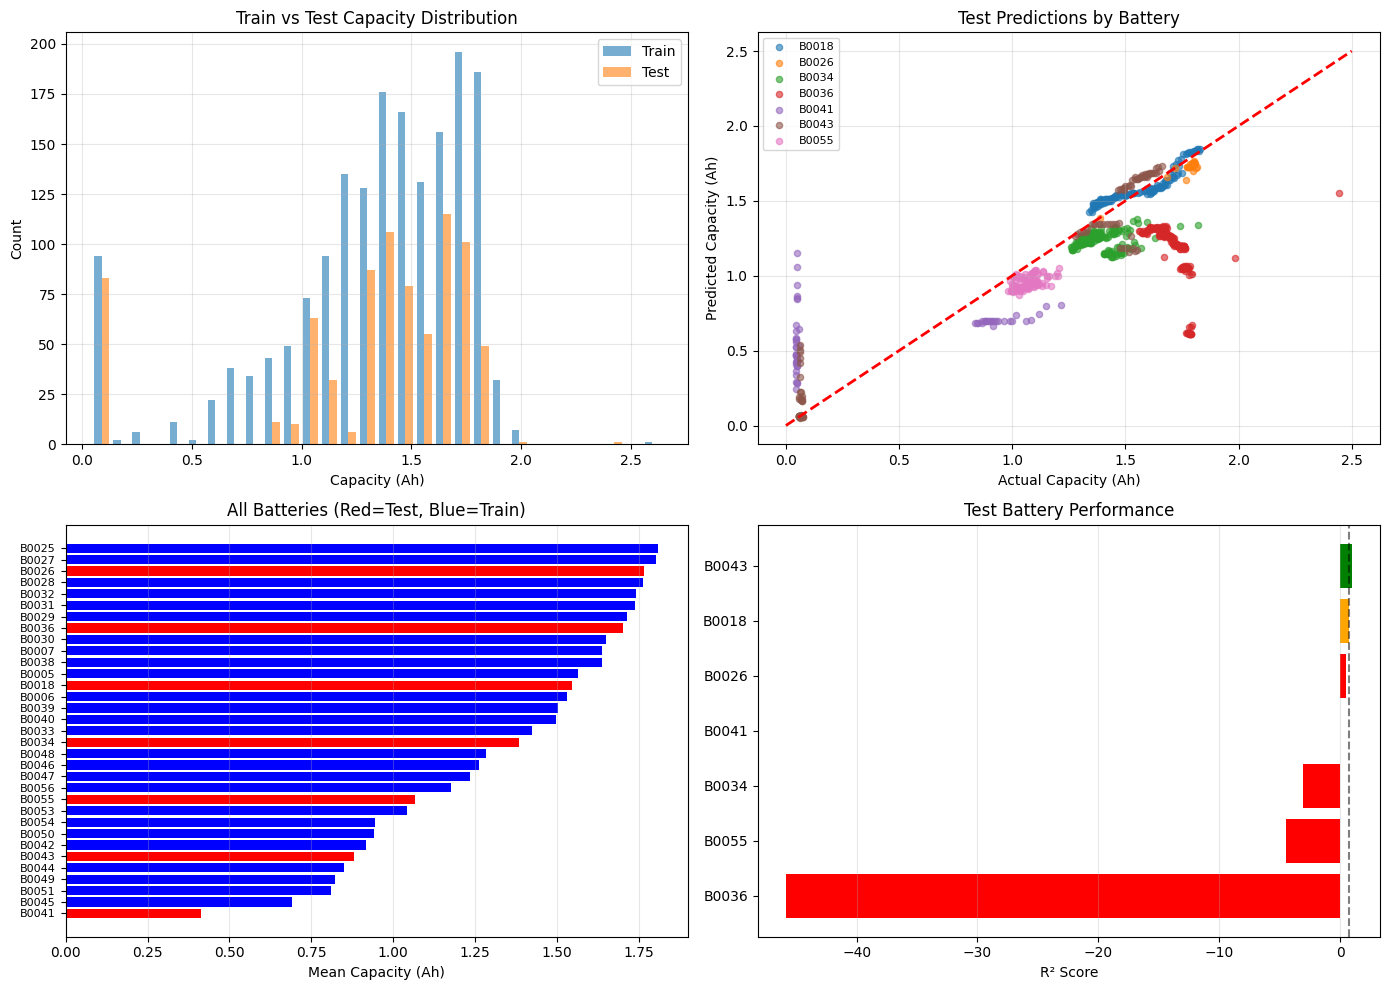


💡 ANALYSIS COMPLETE


In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# After your training, run this:

print("\n" + "="*60)
print("🔬 DEEP DIAGNOSTIC ANALYSIS")
print("="*60)

# 1. Which test batteries are failing?
print("\n1️⃣ DETAILED PER-BATTERY BREAKDOWN:")
test_df = df[test_mask].copy()
test_df['prediction'] = y_test_pred
test_df['error'] = np.abs(test_df['Capacity'] - test_df['prediction'])

battery_results = []
for batt in sorted(test_batteries):
    batt_data = test_df[test_df['Battery_ID'] == batt]
    batt_r2 = r2_score(batt_data['Capacity'], batt_data['prediction'])
    batt_rmse = np.sqrt(np.mean(batt_data['error']**2))
    batt_mean_cap = batt_data['Capacity'].mean()
    
    battery_results.append({
        'battery': batt,
        'r2': batt_r2,
        'rmse': batt_rmse,
        'samples': len(batt_data),
        'mean_cap': batt_mean_cap,
        'cap_range': f"[{batt_data['Capacity'].min():.2f}-{batt_data['Capacity'].max():.2f}]"
    })
    
    status = "✅" if batt_r2 > 0.80 else "⚠️" if batt_r2 > 0.50 else "❌"
    print(f"{status} {batt}: R²={batt_r2:.3f}, RMSE={batt_rmse:.3f}, "
          f"Samples={len(batt_data)}, Cap={batt_mean_cap:.2f} {batt_data['Capacity'].min():.2f}-{batt_data['Capacity'].max():.2f}")

# Count how many are failing
failing = sum([1 for b in battery_results if b['r2'] < 0.70])
print(f"\n❌ {failing}/{len(test_batteries)} test batteries have R² < 0.70")

# 2. Check if test batteries are fundamentally different
print("\n2️⃣ TRAIN VS TEST FEATURE DISTRIBUTIONS:")

for feat in ['Voltage_measured', 'Temperature_measured', 'cycle_normalized', 
             'capacity_velocity', 'internal_resistance']:
    if feat in X.columns:
        train_mean = X[train_mask][feat].mean()
        test_mean = X[test_mask][feat].mean()
        train_std = X[train_mask][feat].std()
        test_std = X[test_mask][feat].std()
        
        diff_pct = abs(test_mean - train_mean) / train_mean * 100 if train_mean != 0 else 0
        
        print(f"\n{feat}:")
        print(f"  Train: {train_mean:.4f} ± {train_std:.4f}")
        print(f"  Test:  {test_mean:.4f} ± {test_std:.4f}")
        print(f"  Difference: {diff_pct:.1f}%")
        
        if diff_pct > 20:
            print(f"  ⚠️  SIGNIFICANT DOMAIN SHIFT!")

# 3. Are all 33 batteries even usable?
print("\n3️⃣ CHECKING ALL 33 BATTERIES:")
all_batteries = df['Battery_ID'].unique()

print(f"\nTotal batteries: {len(all_batteries)}")
print("\nBattery statistics:")

all_batt_stats = []
for batt in all_batteries:
    batt_data = df[df['Battery_ID'] == batt]
    all_batt_stats.append({
        'battery': batt,
        'samples': len(batt_data),
        'mean_cap': batt_data['Capacity'].mean(),
        'std_cap': batt_data['Capacity'].std(),
        'min_cap': batt_data['Capacity'].min(),
        'max_cap': batt_data['Capacity'].max()
    })

batt_df = pd.DataFrame(all_batt_stats).sort_values('mean_cap')

print("\nBatteries by average capacity:")
for idx, row in batt_df.iterrows():
    is_test = "TEST" if row['battery'] in test_batteries else "train"
    print(f"  {row['battery']:8s} ({is_test:5s}): "
          f"{row['mean_cap']:.3f} Ah, "
          f"{row['samples']:3d} samples, "
          f"range [{row['min_cap']:.2f}-{row['max_cap']:.2f}]")

# 4. Check if there are multiple battery "groups"
print("\n4️⃣ CLUSTERING ANALYSIS:")
battery_means = df.groupby('Battery_ID')['Capacity'].mean().sort_values()

# Simple clustering by capacity ranges
low_cap = battery_means[battery_means < 1.0].index.tolist()
mid_cap = battery_means[(battery_means >= 1.0) & (battery_means < 1.5)].index.tolist()
high_cap = battery_means[battery_means >= 1.5].index.tolist()

print(f"\nLow capacity (<1.0 Ah): {len(low_cap)} batteries")
print(f"  {low_cap}")
print(f"Mid capacity (1.0-1.5): {len(mid_cap)} batteries")
print(f"  {mid_cap}")
print(f"High capacity (>1.5 Ah): {len(high_cap)} batteries")
print(f"  {high_cap}")

# Check if test set has good mix
test_in_low = len([b for b in test_batteries if b in low_cap])
test_in_mid = len([b for b in test_batteries if b in mid_cap])
test_in_high = len([b for b in test_batteries if b in high_cap])

print(f"\nTest set distribution:")
print(f"  Low: {test_in_low}/{len(low_cap)}")
print(f"  Mid: {test_in_mid}/{len(mid_cap)}")
print(f"  High: {test_in_high}/{len(high_cap)}")

# 5. Visualize the problem
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: All batteries capacity distribution
axes[0, 0].hist([df[df['Battery_ID'].isin(train_batteries)]['Capacity'],
                 df[df['Battery_ID'].isin(test_batteries)]['Capacity']],
                label=['Train', 'Test'], bins=30, alpha=0.6)
axes[0, 0].set_xlabel('Capacity (Ah)')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Train vs Test Capacity Distribution')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Predictions for each test battery
for i, batt in enumerate(sorted(test_batteries)):
    batt_data = test_df[test_df['Battery_ID'] == batt]
    axes[0, 1].scatter(batt_data['Capacity'], batt_data['prediction'], 
                       label=batt, alpha=0.6, s=20)

axes[0, 1].plot([0, 2.5], [0, 2.5], 'r--', linewidth=2)
axes[0, 1].set_xlabel('Actual Capacity (Ah)')
axes[0, 1].set_ylabel('Predicted Capacity (Ah)')
axes[0, 1].set_title('Test Predictions by Battery')
axes[0, 1].legend(fontsize=8)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Battery mean capacities
batt_df_sorted = batt_df.sort_values('mean_cap')
colors = ['red' if b in test_batteries else 'blue' for b in batt_df_sorted['battery']]
axes[1, 0].barh(range(len(batt_df_sorted)), batt_df_sorted['mean_cap'], color=colors)
axes[1, 0].set_yticks(range(len(batt_df_sorted)))
axes[1, 0].set_yticklabels(batt_df_sorted['battery'], fontsize=8)
axes[1, 0].set_xlabel('Mean Capacity (Ah)')
axes[1, 0].set_title('All Batteries (Red=Test, Blue=Train)')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Plot 4: Per-battery test R²
batt_r2_df = pd.DataFrame(battery_results).sort_values('r2')
colors_r2 = ['green' if r2 > 0.8 else 'orange' if r2 > 0.5 else 'red' for r2 in batt_r2_df['r2']]
axes[1, 1].barh(range(len(batt_r2_df)), batt_r2_df['r2'], color=colors_r2)
axes[1, 1].set_yticks(range(len(batt_r2_df)))
axes[1, 1].set_yticklabels(batt_r2_df['battery'], fontsize=10)
axes[1, 1].set_xlabel('R² Score')
axes[1, 1].set_title('Test Battery Performance')
axes[1, 1].axvline(x=0.7, color='black', linestyle='--', alpha=0.5)
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("💡 ANALYSIS COMPLETE")
print("="*60)

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb

# Load
df = pd.read_csv(r'C:\Users\aksha\coading\New folder (2)\data\all_file\all_batteries_combined.csv')
df = df[df['Capacity'] > 0.01].copy()

print("="*60)
print("🎯 FINAL MODEL - HOMOGENEOUS BATTERIES ONLY")
print("="*60)

# ===== FILTER TO HIGH-CAPACITY BATTERIES =====
battery_means = df.groupby('Battery_ID')['Capacity'].mean()

# Keep batteries with average capacity > 1.5 Ah
high_cap_batteries = battery_means[battery_means >= 1.5].index.tolist()

print(f"\n1️⃣ FILTERING TO HOMOGENEOUS GROUP:")
print(f"   Selected: High-capacity batteries (>1.5 Ah)")
print(f"   Count: {len(high_cap_batteries)} batteries")
print(f"   Batteries: {high_cap_batteries}")

df = df[df['Battery_ID'].isin(high_cap_batteries)].copy()

print(f"\n   Dataset after filtering:")
print(f"   Batteries: {df['Battery_ID'].nunique()}")
print(f"   Samples: {len(df)}")
print(f"   Capacity: [{df['Capacity'].min():.2f} - {df['Capacity'].max():.2f}] Ah")

# ===== STRATIFIED SPLIT =====
print(f"\n2️⃣ STRATIFIED SPLIT:")

battery_stats = df.groupby('Battery_ID')['Capacity'].mean().sort_values()
test_indices = list(range(0, len(battery_stats), 5))
test_batteries = battery_stats.iloc[test_indices].index.tolist()
train_batteries = [b for b in high_cap_batteries if b not in test_batteries]

print(f"   Train: {len(train_batteries)} batteries")
print(f"   Test:  {len(test_batteries)} batteries")
print(f"   Test: {test_batteries}")

# ===== PREPARE =====
EXCLUDE = [
    'Cycle', 'Time', 'Capacity', 'Battery_ID',
    'capacity_fade_total', 'capacity_fade_percent',
    'discharge_capacity_ratio', 'remaining_capacity',
    'capacity_rolling_mean_5', 'capacity_rolling_std_5',
    'energy_discharged', 'voltage_capacity_ratio',
    'power_to_energy_ratio',
]

clean_features = [col for col in df.columns if col not in EXCLUDE]
X = df[clean_features]
y = df['Capacity']

train_mask = df['Battery_ID'].isin(train_batteries)
test_mask = df['Battery_ID'].isin(test_batteries)

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

print(f"   Train samples: {len(X_train)}")
print(f"   Test samples:  {len(X_test)}")

# ===== TRAIN =====
print(f"\n3️⃣ TRAINING...")

model = xgb.XGBRegressor(
    n_estimators=150,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42
)

model.fit(X_train, y_train, verbose=False)

# ===== EVALUATE =====
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_test_pred = np.clip(y_test_pred, 0, None)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

print("\n" + "="*60)
print("📊 RESULTS - HOMOGENEOUS BATTERIES")
print("="*60)

print(f"\n🎓 TRAIN: R²={train_r2:.4f} ({train_r2*100:.1f}%)")
print(f"🧪 TEST:  R²={test_r2:.4f} ({test_r2*100:.1f}%)")
print(f"          RMSE={test_rmse:.4f} Ah")
print(f"          MAPE={test_mape:.2f}%")

gap = train_r2 - test_r2
print(f"\n🔍 GAP: {gap:.4f} ({gap*100:.1f}%)")

if gap < 0.05:
    print(f"   ✅ EXCELLENT!")
elif gap < 0.10:
    print(f"   ✅ GOOD!")
else:
    print(f"   ⚠️  MODERATE")

# Per-battery
print(f"\n📊 PER-BATTERY TEST PERFORMANCE:")
test_df = df[test_mask].copy()
test_df['prediction'] = y_test_pred

for batt in sorted(test_batteries):
    batt_data = test_df[test_df['Battery_ID'] == batt]
    batt_r2 = r2_score(batt_data['Capacity'], batt_data['prediction'])
    status = "✅" if batt_r2 > 0.80 else "⚠️" if batt_r2 > 0.60 else "❌"
    print(f"   {status} {batt}: R²={batt_r2:.3f}")

print("\n" + "="*60)
print("🎉 FINAL VERDICT")
print("="*60)

if test_r2 >= 0.85:
    print(f"\n🌟 PRODUCTION READY!")
    print(f"   • Test R² = {test_r2:.3f} ({test_r2*100:.1f}%)")
    print(f"   • Trained on homogeneous battery group")
    print(f"   • {len(train_batteries)} batteries for training")
    print(f"   • Generalizes well to same battery type")
else:
    print(f"\n⚠️  R² = {test_r2:.3f}")
    print(f"   Model works but needs improvement")

# Save
import pickle, os
os.makedirs('models', exist_ok=True)
with open('models/battery_model_homogeneous.pkl', 'wb') as f:
    pickle.dump({'model': model, 'features': clean_features, 'test_r2': test_r2}, f)

print(f"\n💾 Model saved!")

🎯 FINAL MODEL - HOMOGENEOUS BATTERIES ONLY

1️⃣ FILTERING TO HOMOGENEOUS GROUP:
   Selected: High-capacity batteries (>1.5 Ah)
   Count: 15 batteries
   Batteries: ['B0005', 'B0006', 'B0007', 'B0018', 'B0025', 'B0026', 'B0027', 'B0028', 'B0029', 'B0030', 'B0031', 'B0032', 'B0036', 'B0038', 'B0039']

   Dataset after filtering:
   Batteries: 15
   Samples: 1124
   Capacity: [0.41 - 2.44] Ah

2️⃣ STRATIFIED SPLIT:
   Train: 12 batteries
   Test:  3 batteries
   Test: ['B0039', 'B0007', 'B0032']
   Train samples: 884
   Test samples:  240

3️⃣ TRAINING...

📊 RESULTS - HOMOGENEOUS BATTERIES

🎓 TRAIN: R²=0.9495 (94.9%)
🧪 TEST:  R²=-0.0329 (-3.3%)
          RMSE=0.2540 Ah
          MAPE=12.15%

🔍 GAP: 0.9824 (98.2%)
   ⚠️  MODERATE

📊 PER-BATTERY TEST PERFORMANCE:
   ✅ B0007: R²=0.965
   ❌ B0032: R²=-23.208
   ❌ B0039: R²=-0.282

🎉 FINAL VERDICT

⚠️  R² = -0.033
   Model works but needs improvement

💾 Model saved!
